In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from spatialinfo import spatial_information as si
from spatialinfo import utils 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import PoissonRegressor

# Time decoding

## References
- [Tsao et al., 2018 (Nature): Integrating time from experience in the lateral entorhinal cortex.](https://www.nature.com/articles/s41586-018-0459-6)
- [Howard et al., 2014 (J. Neurosci.): A Unified Mathematical Framework for Coding Time, Space,and Sequences in the Hippocampal Region.](https://www.jneurosci.org/lookup/doi/10.1523/JNEUROSCI.5808-12.2014)

In [48]:
# Import dataset
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20241011_Dl_3\\'))
bh = si.remove_interpolated_values(bh, n_corr=2)
bh = si.add_trial_column(bh)
activity_data, spatial_data = si.temporal_binning(dff, bh, sec_per_bin=0.5, only_moving=False)
binned_data = utils.binning_function(bh, sec_per_bin=0.5)

## Fitting a GLM 

From Tsao et al., 2018:

> GLM fitting. A Poisson GLM was fit to each cell individually using the MATLAB stepwiseglm function. The variables used to fit the model for BW12 data were wallcolour, position, trial time, and session time. A single predictor was used for each variable. Session time was the total elapsed time, and took into account intertrial periods. Adjusted R2 was used as the criterion for adding or removing terms (0.01 for adding, 0.005 for removing). Firing rate was estimated for 500-ms bins, with no smoothing or additional preprocessing. The same process was used for the object and figure-eight data, excluding position as a variable.

In [49]:
y = activity_data
y = y - y.min(axis=0, keepdims=True)
# y = binned_data["trial_time"]

X = binned_data[["trial_time", "session_time", "X", "Y"]]

for j in range(activity_data.shape[1]):
    PoiReg = PoissonRegressor()
    PoiReg.fit(X, y[:,j])
    if np.any(abs(PoiReg.coef_) > 0.01):

        #fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5,1, figsize=(12,8))
        print(j)
        #ax1.plot(y[:,j])
        #ax2.plot(X["trial_time"])
        #ax3.plot(X["session_time"])
        #ax4.plot(X["X"])
        #ax5.plot(X["Y"])
        #plt.show()

#plt.figure(figsize=(15,5))
#plt.plot(y)
#PoiReg.fit(X, y)
#print(PoiReg.score(X, y))
#id_crit = abs(PoiReg.coef_) > 0.01
#print(sum(id_crit)/len(id_crit))
#id = np.where(abs(PoiReg.coef_)>0.01)[0]#

#fig, [ax1, ax2] = plt.subplots(2,1, figsize=(16,8))
#id
#ax1.plot(X[:,id[:]])
#ax2.plot(y)

0
1
2
4
7
11
13
14
16
18
21
23
30


c:\Users\anneluka\.conda\envs\SpatialInformation\Lib\site-packages\sklearn\linear_model\_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


## LOOCV for trials 

> To quantify the temporal information present, we trained a linear multiclass support vector machine to identify temporal epochs (trial 1,intertrial 1, trial 2, and so on) based on neural activity from individual animals, pooled across recording sessions. Population activity defined by the firing rates of cells was binned into 10 s bins, with each bin labelled by the temporal epoch it was in. The decoder was then trained to identify temporal epochs based on population activity, with tenfold cross-validation (Extended Data Fig. 4d). Statistical significance was evaluated using a permutation method (see Methods). Very high decoding accuracy for temporal epoch identity across the whole session spanning both trial and intertrial periods was observed for all LEC animals during the BW12 experiment, indicating substantial temporal information was present in LEC population activity (88.0% mean accuracy, chance level 4.2%; Fig. 3a).

In [17]:
int(bin)

39

In [50]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    activity_data, np.array(binned_data["trial"]), test_size=0.1, random_state=42)

clf = svm.SVC()
clf.fit(X_train, y_train)

confmatrix = np.zeros((len(np.unique(y_train)), len(np.unique(y_train))))
for vector, bin in zip(X_test, y_test):
    
    pred_bin = clf.predict(vector.reshape(1,-1))
    bin_val = int(bin[0]) if isinstance(bin, np.ndarray) else int(bin)
    print(bin_val)
    pred_val = int(pred_bin[0]) if isinstance(pred_bin, np.ndarray) else int(pred_bin)
    print(pred_val)
    confmatrix[bin_val-1, pred_val-1] += 1



41
42
30
30
24
24
1
1
34
34
43
43
22
19
43
43
2
2
17
11
18
18
48
45
37
37
8
2
17
11
11
11
10
16
3
3
32
33
25
25
31
31
29
29
13
13
2
2
7
7
35
35
43
43
42
42
31
31
34
34
31
31
0
0
3
3
45
48
4
4
14
14
18
18
45
48
36
36
42
42
49
49
2
10
29
28
19
11
9
9
42
31
46
46
44
44
43
43
0
0
33
33
44
44
34
34
47
47
33
33
10
10
25
25
33
32
47
47
30
30
4
4
10
10
29
29
18
2
12
12
41
41
17
19
0
0
11
11
33
33
38
34
48
48
39
39
34
35
45
45
45
45
29
29
40
37
26
26
43
43
41
41
11
11
45
45
21
26
47
47
3
3
13
13
17
17
34
34
14
14
8
10
2
2
43
43
32
32
29
29
33
33
43
43
47
47
13
13
34
34
31
31
44
44
2
2
35
34
33
33
31
31
33
30
1
2
42
42
32
32
5
45
25
25
30
30
36
36
19
19
38
34
47
47
10
10
10
10
2
2
24
21
29
29
39
39
14
14
13
4
48
48
1
1
45
42
23
22
31
31
39
33
20
20
7
4
39
39
11
11
44
44
31
31
17
18
7
7
35
33
37
34
46
46
16
16
28
19
29
29
47
44
32
32
34
35
21
20
16
27
17
17
12
12
17
17
31
31
46
46
44
44
45
45
18
18
32
32
45
45
10
10
32
32
1
1
3
3
16
16
38
38
11
11
37
37
20
20
38
34
12
12
32
33
8
8
15
13
34
34
40


<Axes: >

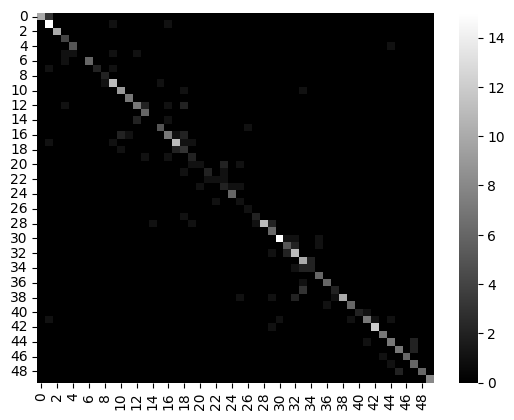

In [51]:
import seaborn as sns 
sns.heatmap(confmatrix, fmt="d", cmap='gist_gray')

6 selective neurons out of 39


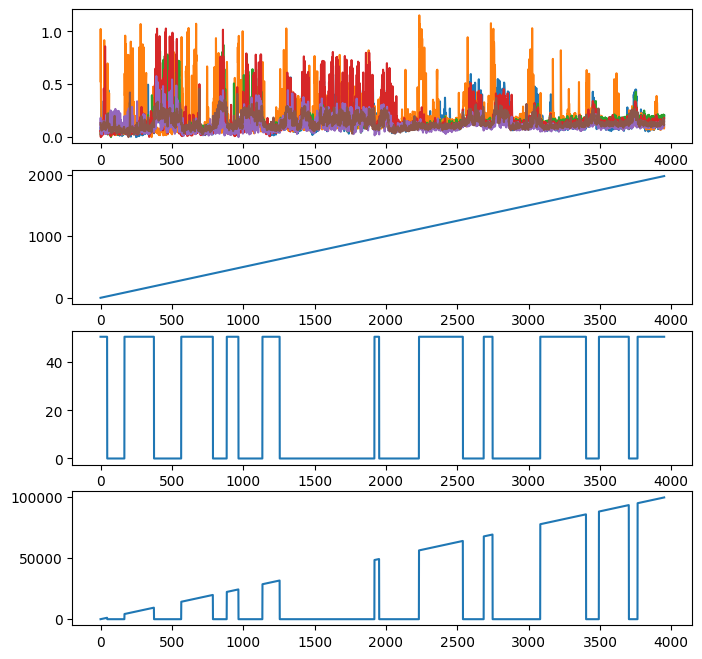

In [52]:
X = activity_data
X_shifted = X - X.min(axis=0, keepdims=True)

# Targets: e.g., Y position and trial time (each of shape (n_samples,))
y1 = binned_data["session_time"]
y2 = binned_data["X"]

# Stack targets as predictors (e.g., for encoding modeling)
# Here we model Y_position and trial_time → neural activity
joint_input = np.column_stack([y1, y2])

# Include interaction term
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_joint = poly.fit_transform(joint_input)

# Now fit a Poisson model to each neuron separately to check encoding
selective_neurons = []
for i in range(X_shifted.shape[1]):
    model = PoissonRegressor(alpha=0.1)
    model.fit(X_joint, X_shifted[:, i])
    score = model.score(X_joint, X_shifted[:, i])
    coef = model.coef_
    
    # Select neurons with substantial coefficients
    if np.any(np.abs(coef) > 0.01):
        selective_neurons.append(i)

print(f"{len(selective_neurons)} selective neurons out of {X_shifted.shape[1]}")

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(8,8))

ax1.plot(X_shifted[:,selective_neurons[:]])
ax2.plot(X_joint[:,0])
ax3.plot(X_joint[:,1])
ax4.plot(X_joint[:,2])

In [37]:
binned_data


,X,Y,trial,session_time,trial_time
0,-0.0,19.500000,0.0,0.0,0.0
1,0.0,19.500000,0.0,0.5,0.5
2,0.0,19.500000,0.0,1.0,1.0
3,0.0,19.500000,0.0,1.5,1.5
4,0.0,19.500000,0.0,2.0,2.0
...,...,...,...,...,...
357,0.0,106.733103,38.0,178.5,1.0
358,0.0,124.478385,38.0,179.0,1.5
359,0.0,124.480000,38.0,179.5,2.0
360,0.0,124.480000,38.0,180.0,2.5
